In [1]:
%pip install unidecode
%pip install folium

Note: you may need to restart the kernel to use updated packages.



In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import json
from unidecode import unidecode

In [3]:
ufs = ['RS', 'SC', 'PR']

# Primeiro passo

In [4]:
df_ocorrencia = pd.read_csv("../dados/acidentes/por ocorrencia/datatran_agrupado.csv", sep=",")
df_ocorrencia = df_ocorrencia[df_ocorrencia['uf'].isin(ufs)]
df_ocorrencia.head()

C:\Users\adria\AppData\Local\Temp\ipykernel_12604\1849590759.py:1: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ocorrencia = pd.read_csv("../dados/acidentes/por ocorrencia/datatran_agrupado.csv", sep=",")


,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,origem_arquivo
1,405158.0,2022-01-01,sábado,02:40:00,PR,116,33,CAMPINA GRANDE DO SUL,Ingestão de álcool pelo condutor,Tombamento,...,0,1,1,2,"-25,114403","-48,8467554",SPRF-PR,DEL01-PR,UOP02-DEL01-PR,datatran2022.csv
7,405234.0,2022-01-01,sábado,08:05:00,SC,163,"80,1",GUARACIABA,Ausência de reação do condutor,Colisão frontal,...,0,1,2,3,"-26,65043908","-53,5185463",SPRF-SC,DEL07-SC,UOP03-DEL07-SC,datatran2022.csv
8,405247.0,2022-01-01,sábado,12:20:00,SC,101,"139,7",BALNEARIO CAMBORIU,Condutor deixou de manter distância do veículo...,Colisão traseira,...,3,1,1,4,"-27,02982303","-48,60115006",SPRF-SC,DEL04-SC,UOP03-DEL04-SC,datatran2022.csv
22,405395.0,2022-01-02,domingo,07:10:00,PR,116,"8,4",CAMPINA GRANDE DO SUL,Condutor Dormindo,Saída de leito carroçável,...,0,1,2,2,"-25,08123277","-48,62449108",SPRF-PR,DEL01-PR,UOP02-DEL01-PR,datatran2022.csv
23,405408.0,2022-01-02,domingo,08:20:00,SC,470,"204,1",PONTE ALTA,Velocidade Incompatível,Colisão lateral sentido oposto,...,1,0,3,2,"-27,289373","-50,166328",SPRF-SC,DEL05-SC,UOP03-DEL05-SC,datatran2022.csv


In [5]:
df_ocorrencia.shape

(69261, 31)

In [5]:
# Lista de causas que poderiam ser evitadas com radar
causas_relacionadas_velocidade = [
    "Velocidade Incompatível",
    "Participar de racha",
    "Condutor deixou de manter distância do veículo da frente",
    "Reação tardia ou ineficiente do condutor",
    "Transitar na contramão",
    "Ultrapassagem Indevida",
    "Frear bruscamente",
    "Condutor usando celular",
    "Transitar no acostamento",
    "Transitar no Acostamento"
]

# Filtrar dataframe
df_ocorrencia = df_ocorrencia[
    df_ocorrencia['causa_acidente'].isin(causas_relacionadas_velocidade)
]

# Visualizar
print(f"Total de acidentes relacionados à velocidade: {len(df_ocorrencia)}")

Total de acidentes relacionados à velocidade: 24252


In [6]:
df_ocorrencia.shape

(24252, 31)

In [7]:
df_ocorrencia['latitude'] = df_ocorrencia['latitude'].str.replace(',', '.')
df_ocorrencia['longitude'] = df_ocorrencia['longitude'].str.replace(',', '.')

df_ocorrencia = df_ocorrencia.dropna(subset=['latitude'])
df_ocorrencia = df_ocorrencia.dropna(subset=['longitude'])

df_ocorrencia['latitude'] = pd.to_numeric(df_ocorrencia['latitude'], errors='coerce')
df_ocorrencia['longitude'] = pd.to_numeric(df_ocorrencia['longitude'], errors='coerce')
df_ocorrencia.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,origem_arquivo
8,405247.0,2022-01-01,sábado,12:20:00,SC,101,"139,7",BALNEARIO CAMBORIU,Condutor deixou de manter distância do veículo...,Colisão traseira,...,3,1,1,4,-27.029823,-48.601150,SPRF-SC,DEL04-SC,UOP03-DEL04-SC,datatran2022.csv
23,405408.0,2022-01-02,domingo,08:20:00,SC,470,"204,1",PONTE ALTA,Velocidade Incompatível,Colisão lateral sentido oposto,...,1,0,3,2,-27.289373,-50.166328,SPRF-SC,DEL05-SC,UOP03-DEL05-SC,datatran2022.csv
28,405442.0,2022-01-02,domingo,12:00:00,SC,116,54,PAPANDUVA,Velocidade Incompatível,Tombamento,...,1,1,2,2,-26.394484,-50.164800,SPRF-SC,DEL06-SC,UOP02-DEL06-SC,datatran2022.csv
33,405524.0,2022-01-02,domingo,18:00:00,PR,153,"504,7",GENERAL CARNEIRO,Velocidade Incompatível,Capotamento,...,0,0,1,1,-26.515574,-51.357023,SPRF-PR,DEL02-PR,UOP03-DEL02-PR,datatran2022.csv
39,405599.0,2022-01-03,segunda-feira,07:20:00,SC,101,120,ITAJAI,Condutor deixou de manter distância do veículo...,Colisão traseira,...,1,1,1,3,-26.912758,-48.711998,SPRF-SC,DEL04-SC,UOP04-DEL04-SC,datatran2022.csv


# Segundo passo

In [8]:
acidentes = gpd.GeoDataFrame(
    df_ocorrencia,
    geometry=gpd.points_from_xy(df_ocorrencia['longitude'], df_ocorrencia['latitude']),
    crs="EPSG:4326"
)

# Terceiro passo

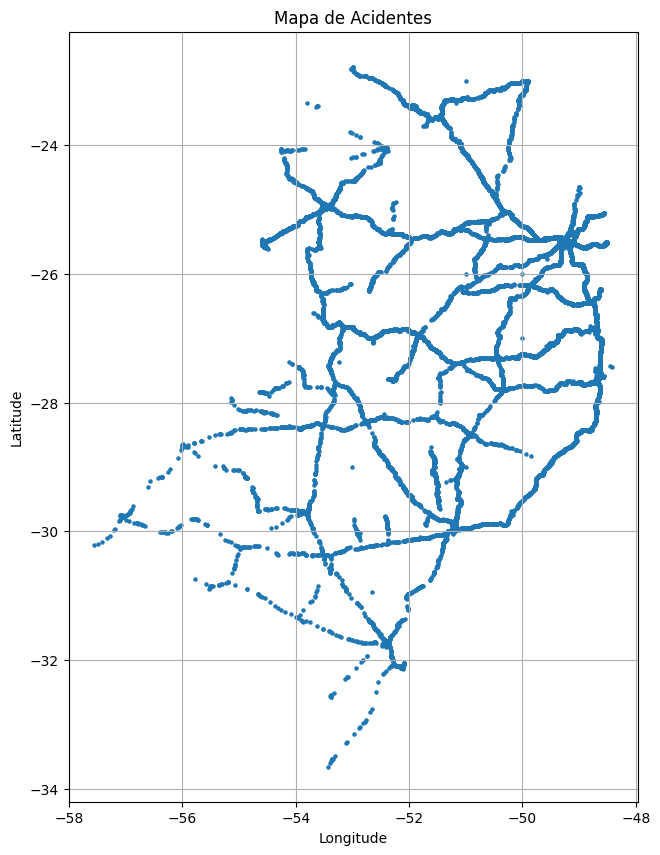

In [9]:
# Assumindo que 'acidentes' já é um GeoDataFrame com geometria definida
acidentes.plot(figsize=(10, 10), markersize=5)

plt.title('Mapa de Acidentes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


# Terceiro passo (interativo)

In [12]:
# Ponto central do mapa (pode ser a média das coordenadas)
lat_centro = acidentes['latitude'].mean()
lon_centro = acidentes['longitude'].mean()

# Cria o mapa interativo
mapa = folium.Map(location=[lat_centro, lon_centro], zoom_start=6, tiles='OpenStreetMap')

# Cluster opcional para melhorar visualização
marker_cluster = MarkerCluster().add_to(mapa)

# Adiciona os pontos
for _, row in acidentes.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,  # equivale ao size=0.2 no R
        color='black',  # cor da borda
        fill=True,
        fill_color='deepskyblue',
        fill_opacity=0.8
    ).add_to(marker_cluster)

# Exibe o mapa
mapa.save("terceiro_passo_interativo.html")

# Quarto passo

In [13]:
# Leitura dos shapefiles de cada estado
rs = gpd.read_file("shapefiles/RS_Municipios_2024.shp").to_crs(epsg=4326)
sc = gpd.read_file("shapefiles/SC_Municipios_2024.shp").to_crs(epsg=4326)
pr = gpd.read_file("shapefiles/PR_Municipios_2024.shp").to_crs(epsg=4326)

# Unifica os três GeoDataFrames
cidades_sul = gpd.GeoDataFrame(pd.concat([rs, sc, pr], ignore_index=True), crs="EPSG:4326")

In [14]:
acidentes = acidentes.to_crs(epsg=4326)

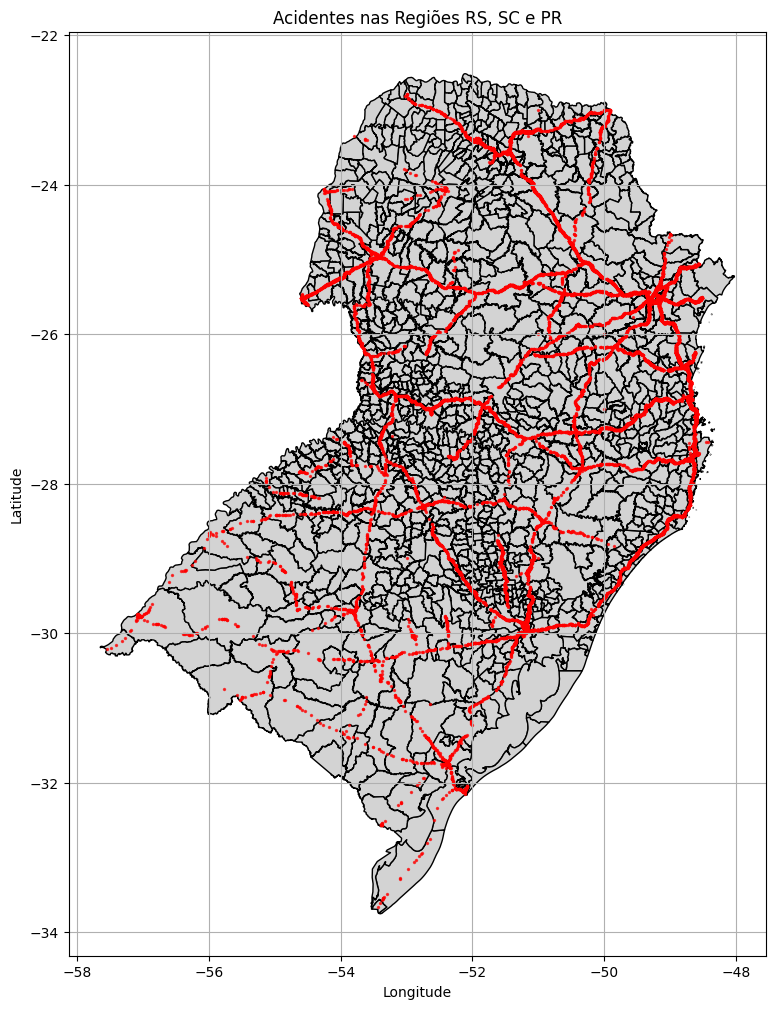

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plotar os polígonos das cidades
cidades_sul.plot(ax=ax, facecolor='lightgray', edgecolor='black')

# Plotar os acidentes como pontos
acidentes.plot(ax=ax, color='red', markersize=2, alpha=0.7)

plt.title("Acidentes nas Regiões RS, SC e PR")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


# Quarto passo (interativo)

In [16]:
# Garante que os GeoDataFrames estão no mesmo CRS
cidades = cidades_sul.to_crs(epsg=4326)
acidentes = acidentes.to_crs(epsg=4326)

# Centro aproximado do mapa
lat_centro = acidentes['geometry'].y.mean()
lon_centro = acidentes['geometry'].x.mean()

# Cria mapa base
mapa = folium.Map(location=[lat_centro, lon_centro], zoom_start=6)

# Adiciona as fronteiras dos municípios (cidades)
folium.GeoJson(
    cidades,
    name="Municípios",
    style_function=lambda feature: {
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0
    }
).add_to(mapa)

# Adiciona os pontos de acidentes
for _, row in acidentes.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(mapa)

# Exibir o mapa
mapa.save("Quarto_passo_interativo.html")

# Quinto passo

In [17]:
cidades = cidades.rename(columns={"NM_MUN": "municipio"})

In [18]:
cidades['municipio'] = cidades['municipio'].apply(lambda x: unidecode(x).upper().strip() if isinstance(x, str) else x)
cidades.head()

,CD_MUN,municipio,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry
0,4316204,RONDINHA,430028,Carazinho,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,252.454,"POLYGON ((-52.91535 -27.88582, -52.91559 -27.8..."
1,4317558,SANTO ANTONIO DO PALMA,430030,Marau,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,126.094,"POLYGON ((-51.99835 -28.43782, -51.99822 -28.4..."
2,4319307,SAO PAULO DAS MISSOES,430024,Cerro Largo,4305,Ijuí,43,Rio Grande do Sul,RS,4,Sul,S,None,None,222.504,"POLYGON ((-54.93828 -28.05575, -54.96888 -28.0..."
3,4311429,LAJEADO DO BUGRE,430034,Palmeira das Missões,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,67.947,"POLYGON ((-53.15215 -27.69941, -53.15493 -27.7..."
4,4318002,SAO BORJA,430017,São Borja,4304,Uruguaiana,43,Rio Grande do Sul,RS,4,Sul,S,None,None,3616.674,"POLYGON ((-56.08158 -28.85668, -56.08628 -28.8..."


In [19]:
acidentes.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,origem_arquivo,geometry
8,405247.0,2022-01-01,sábado,12:20:00,SC,101,"139,7",BALNEARIO CAMBORIU,Condutor deixou de manter distância do veículo...,Colisão traseira,...,1,1,4,-27.029823,-48.601150,SPRF-SC,DEL04-SC,UOP03-DEL04-SC,datatran2022.csv,POINT (-48.60115 -27.02982)
23,405408.0,2022-01-02,domingo,08:20:00,SC,470,"204,1",PONTE ALTA,Velocidade Incompatível,Colisão lateral sentido oposto,...,0,3,2,-27.289373,-50.166328,SPRF-SC,DEL05-SC,UOP03-DEL05-SC,datatran2022.csv,POINT (-50.16633 -27.28937)
28,405442.0,2022-01-02,domingo,12:00:00,SC,116,54,PAPANDUVA,Velocidade Incompatível,Tombamento,...,1,2,2,-26.394484,-50.164800,SPRF-SC,DEL06-SC,UOP02-DEL06-SC,datatran2022.csv,POINT (-50.1648 -26.39448)
33,405524.0,2022-01-02,domingo,18:00:00,PR,153,"504,7",GENERAL CARNEIRO,Velocidade Incompatível,Capotamento,...,0,1,1,-26.515574,-51.357023,SPRF-PR,DEL02-PR,UOP03-DEL02-PR,datatran2022.csv,POINT (-51.35702 -26.51557)
39,405599.0,2022-01-03,segunda-feira,07:20:00,SC,101,120,ITAJAI,Condutor deixou de manter distância do veículo...,Colisão traseira,...,1,1,3,-26.912758,-48.711998,SPRF-SC,DEL04-SC,UOP04-DEL04-SC,datatran2022.csv,POINT (-48.712 -26.91276)


In [20]:
# Garante o mesmo CRS
cidades = cidades.to_crs(epsg=4326)
acidentes = acidentes.to_crs(epsg=4326)

# Renomeia coluna
cidades = cidades.rename(columns={"NM_MUNICIP": "municipio"})

# Join espacial: acidentes dentro de cada município
cidades_acidentes = gpd.sjoin(cidades, acidentes, how="left", predicate="contains")
cidades_acidentes.head()

,CD_MUN,municipio_left,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,...,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,origem_arquivo
0,4316204,RONDINHA,430028,Carazinho,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4317558,SANTO ANTONIO DO PALMA,430030,Marau,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4319307,SAO PAULO DAS MISSOES,430024,Cerro Largo,4305,Ijuí,43,Rio Grande do Sul,RS,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4311429,LAJEADO DO BUGRE,430034,Palmeira das Missões,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,...,1.0,0.0,0.0,2.0,-27.725431,-53.235233,SPRF-RS,DEL08-RS,UOP02-DEL08-RS,datatran2023.csv
3,4311429,LAJEADO DO BUGRE,430034,Palmeira das Missões,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,...,0.0,0.0,2.0,2.0,-27.711136,-53.255325,SPRF-RS,DEL08-RS,UOP02-DEL08-RS,datatran2024.csv


In [21]:

# Conta acidentes por município
# Usar a coluna correta, normalmente 'municipio_left'
cidades_num_acidentes = cidades_acidentes.groupby("municipio_left").size().reset_index(name="num_acidentes")

# Renomear para manter consistência
cidades_num_acidentes = cidades_num_acidentes.rename(columns={"municipio_left": "municipio"})


In [22]:

cidades_com_contagem = cidades.merge(cidades_num_acidentes, on="municipio", how="left")
cidades_com_contagem["num_acidentes"] = cidades_com_contagem["num_acidentes"].fillna(0).astype(int)


In [23]:
cidades.head()

,CD_MUN,municipio,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry
0,4316204,RONDINHA,430028,Carazinho,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,252.454,"POLYGON ((-52.91535 -27.88582, -52.91559 -27.8..."
1,4317558,SANTO ANTONIO DO PALMA,430030,Marau,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,126.094,"POLYGON ((-51.99835 -28.43782, -51.99822 -28.4..."
2,4319307,SAO PAULO DAS MISSOES,430024,Cerro Largo,4305,Ijuí,43,Rio Grande do Sul,RS,4,Sul,S,None,None,222.504,"POLYGON ((-54.93828 -28.05575, -54.96888 -28.0..."
3,4311429,LAJEADO DO BUGRE,430034,Palmeira das Missões,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,67.947,"POLYGON ((-53.15215 -27.69941, -53.15493 -27.7..."
4,4318002,SAO BORJA,430017,São Borja,4304,Uruguaiana,43,Rio Grande do Sul,RS,4,Sul,S,None,None,3616.674,"POLYGON ((-56.08158 -28.85668, -56.08628 -28.8..."


In [24]:
cidades.shape

(1193, 16)

In [25]:
cidades_com_contagem.head()

,CD_MUN,municipio,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry,num_acidentes
0,4316204,RONDINHA,430028,Carazinho,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,252.454,"POLYGON ((-52.91535 -27.88582, -52.91559 -27.8...",1
1,4317558,SANTO ANTONIO DO PALMA,430030,Marau,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,126.094,"POLYGON ((-51.99835 -28.43782, -51.99822 -28.4...",1
2,4319307,SAO PAULO DAS MISSOES,430024,Cerro Largo,4305,Ijuí,43,Rio Grande do Sul,RS,4,Sul,S,None,None,222.504,"POLYGON ((-54.93828 -28.05575, -54.96888 -28.0...",1
3,4311429,LAJEADO DO BUGRE,430034,Palmeira das Missões,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,67.947,"POLYGON ((-53.15215 -27.69941, -53.15493 -27.7...",2
4,4318002,SAO BORJA,430017,São Borja,4304,Uruguaiana,43,Rio Grande do Sul,RS,4,Sul,S,None,None,3616.674,"POLYGON ((-56.08158 -28.85668, -56.08628 -28.8...",18


In [26]:
cidades_com_contagem.to_csv("cidades_num_acidentes.csv", index=False, encoding="utf-8")

# Sexto passo

In [27]:
# Suponha que você queira renomear a coluna 'antigo_nome' para 'novo_nome'
cidades = cidades.rename(columns={"NM_MUN": "municipio"})


In [28]:
# Remover acentuação de toda a coluna 'municipio'
cidades['municipio'] = cidades['municipio'].apply(lambda x: unidecode(x).upper().strip() if isinstance(x, str) else x)

cidades_num_acidentes['municipio'] = cidades_num_acidentes['municipio'].apply(lambda x: unidecode(x) if isinstance(x, str) else x)


In [29]:
print(cidades["municipio"].unique()[:10])
print(cidades_num_acidentes["municipio"].unique()[:10])


['RONDINHA' 'SANTO ANTONIO DO PALMA' 'SAO PAULO DAS MISSOES'
 'LAJEADO DO BUGRE' 'SAO BORJA' 'GARIBALDI' 'LAJEADO' 'NOVA ALVORADA'
 'ARVOREZINHA' 'SAO DOMINGOS DO SUL']
['ABATIA' 'ABDON BATISTA' 'ABELARDO LUZ' 'ACEGUA' 'ADRIANOPOLIS'
 'AGROLANDIA' 'AGRONOMICA' 'AGUA DOCE' 'AGUA SANTA' 'AGUAS DE CHAPECO']


In [30]:
# cidades: GeoDataFrame com geometria dos municípios
# cidades_num_acidentes: DataFrame com ['municipio', 'num_acidentes']

# Junta os dados ao GeoDataFrame original
cidades_com_contagem = cidades.merge(cidades_num_acidentes, on="municipio", how="left")

# Substitui NaN por 0 (sem acidentes)
cidades_com_contagem["num_acidentes"] = cidades_com_contagem["num_acidentes"].fillna(0)

In [31]:
cidades_com_contagem.head()

,CD_MUN,municipio,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry,num_acidentes
0,4316204,RONDINHA,430028,Carazinho,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,252.454,"POLYGON ((-52.91535 -27.88582, -52.91559 -27.8...",1
1,4317558,SANTO ANTONIO DO PALMA,430030,Marau,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,126.094,"POLYGON ((-51.99835 -28.43782, -51.99822 -28.4...",1
2,4319307,SAO PAULO DAS MISSOES,430024,Cerro Largo,4305,Ijuí,43,Rio Grande do Sul,RS,4,Sul,S,None,None,222.504,"POLYGON ((-54.93828 -28.05575, -54.96888 -28.0...",1
3,4311429,LAJEADO DO BUGRE,430034,Palmeira das Missões,4306,Passo Fundo,43,Rio Grande do Sul,RS,4,Sul,S,None,None,67.947,"POLYGON ((-53.15215 -27.69941, -53.15493 -27.7...",2
4,4318002,SAO BORJA,430017,São Borja,4304,Uruguaiana,43,Rio Grande do Sul,RS,4,Sul,S,None,None,3616.674,"POLYGON ((-56.08158 -28.85668, -56.08628 -28.8...",18


In [29]:
%pip install mapclassify

Note: you may need to restart the kernel to use updated packages.


c:\Users\adria\anaconda3\Lib\site-packages\mapclassify\classifiers.py:1767: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


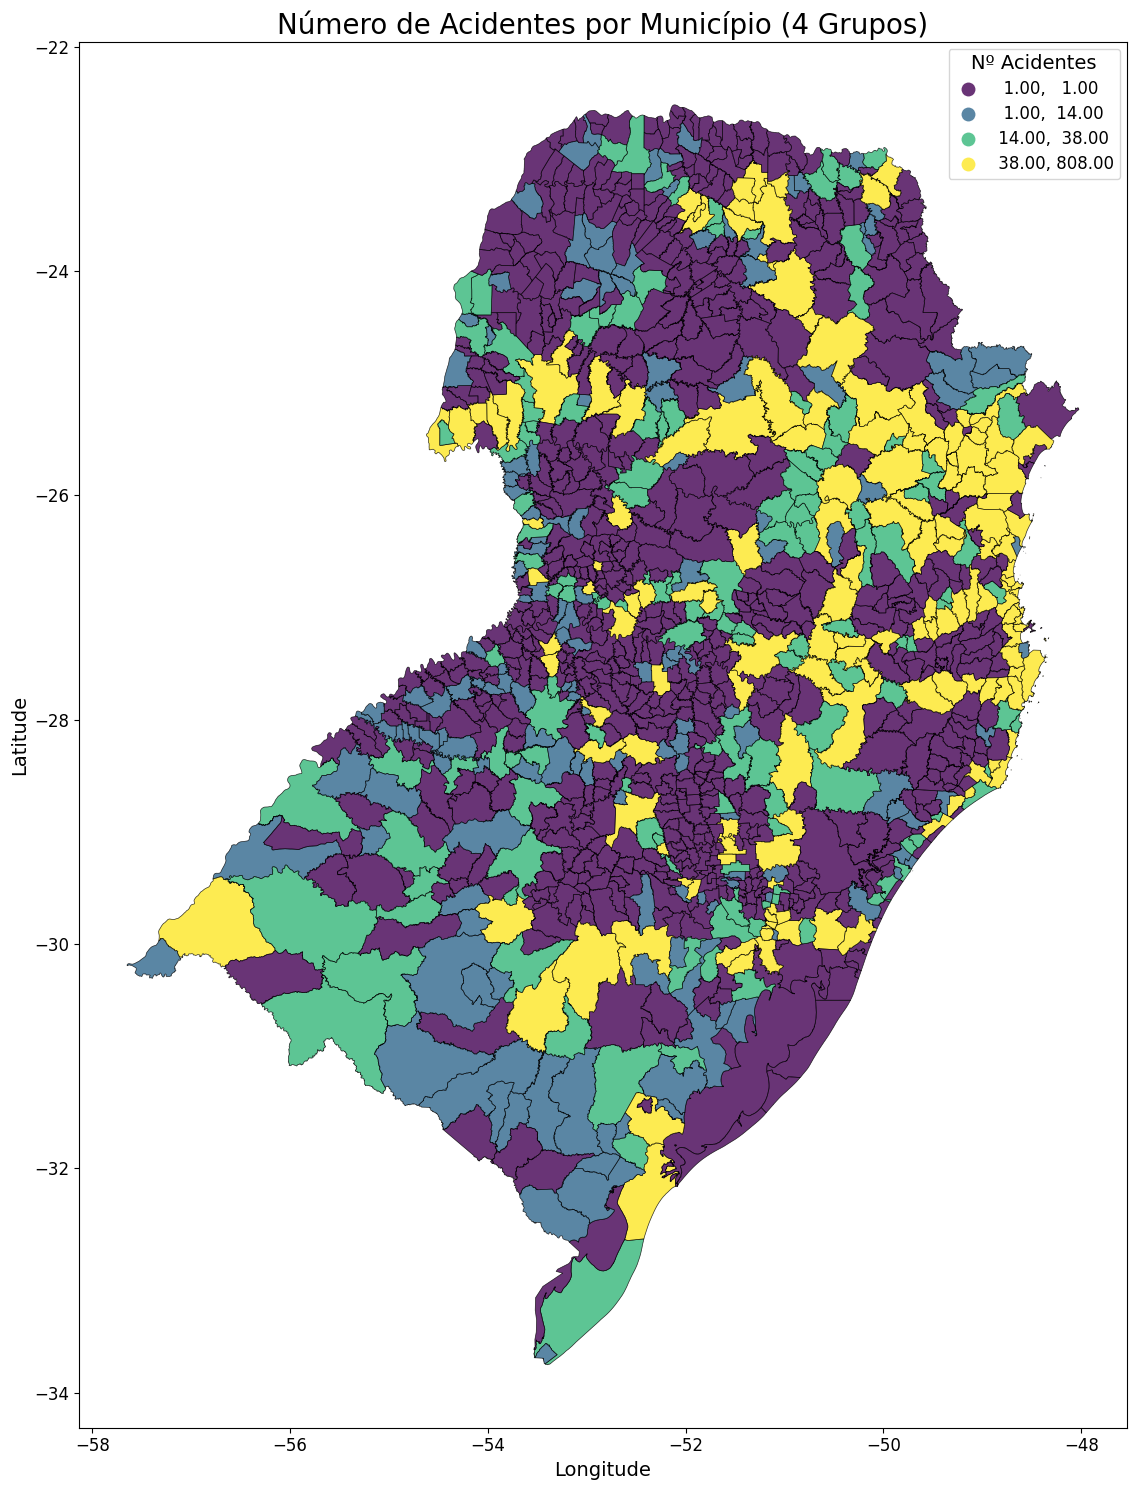

In [33]:
import matplotlib.pyplot as plt
import mapclassify

fig, ax = plt.subplots(figsize=(16, 15))

# Plota e guarda a legenda
legend = cidades_com_contagem.plot(
    column="num_acidentes",
    cmap="viridis",
    scheme="Quantiles",
    k=8,
    linewidth=0.5,
    edgecolor="black",
    alpha=0.8,
    legend=True,
    ax=ax
)

# Título e eixos
ax.set_title("Número de Acidentes por Município (4 Grupos)", fontsize=20)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.tick_params(labelsize=12)  # eixos x e y

# Aumenta o texto da legenda
leg = ax.get_legend()
if leg:
    for text in leg.get_texts():
        text.set_fontsize(12)
    leg.set_title("Nº Acidentes", prop={"size": 14})

plt.tight_layout()
plt.show()


c:\Users\adria\anaconda3\Lib\site-packages\mapclassify\classifiers.py:1767: UserWarning: Not enough unique values in array to form 8 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


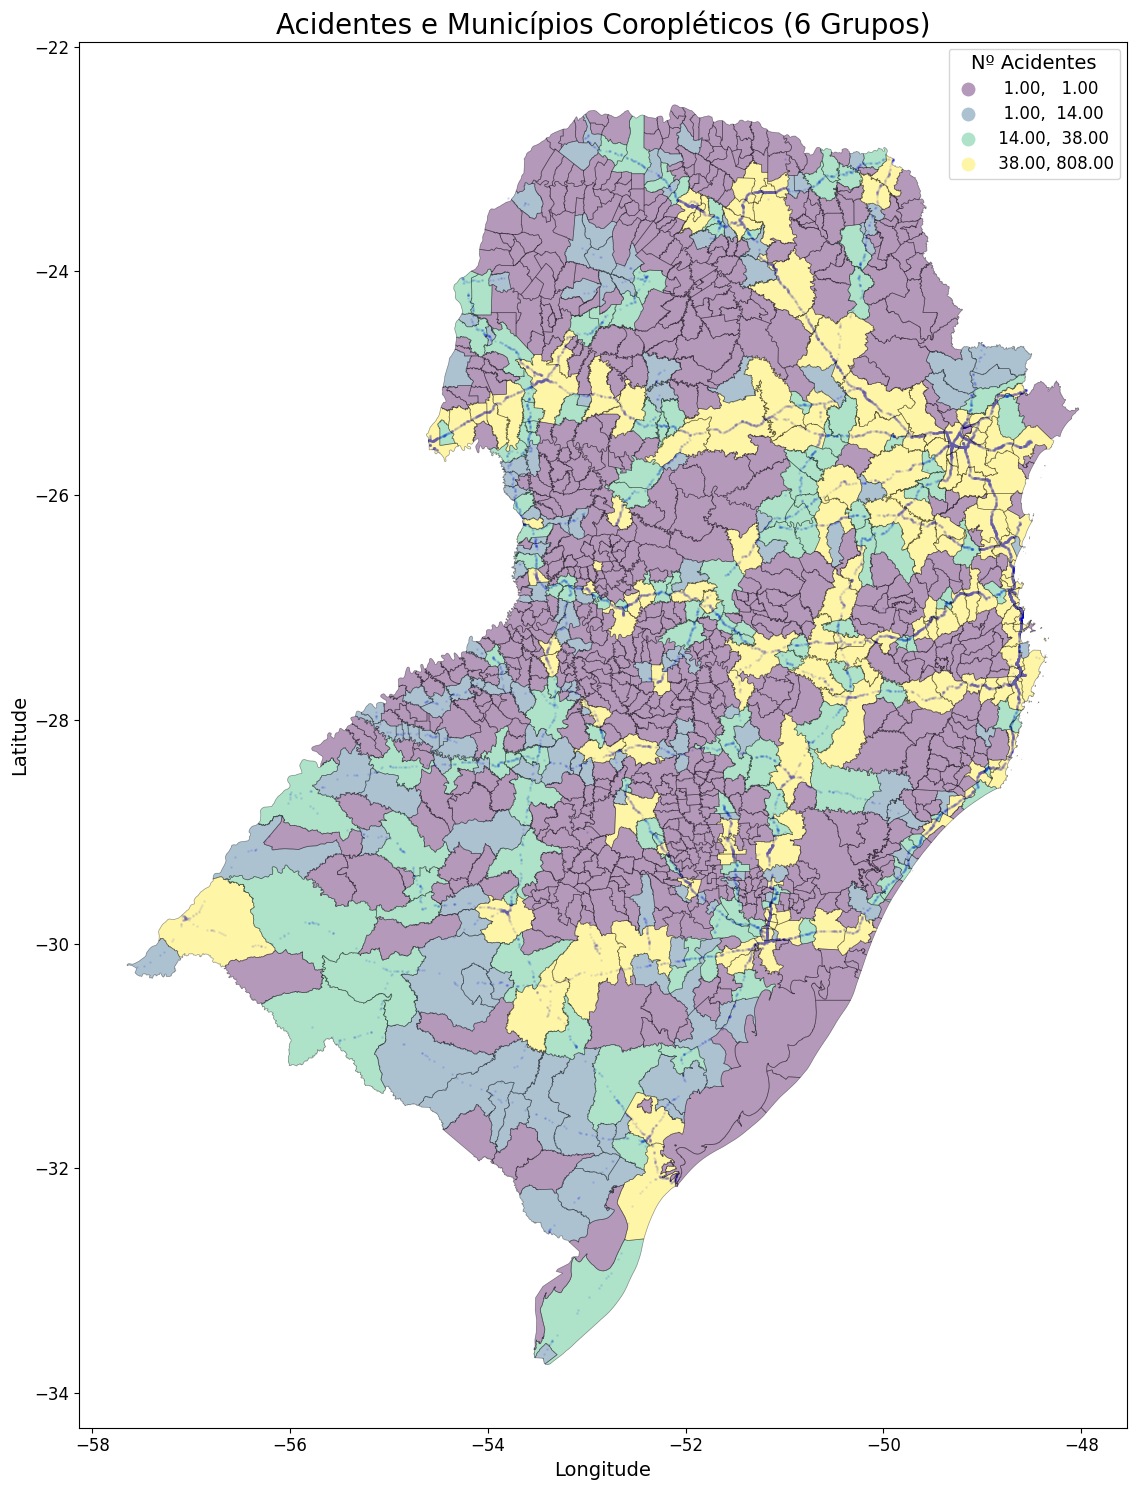

In [34]:
import matplotlib.pyplot as plt
import mapclassify

fig, ax = plt.subplots(figsize=(16, 15))

# 1. Pontos de acidentes
acidentes.plot(
    ax=ax,
    markersize=1,       # Tamanho pequeno
    alpha=0.1,
    color='blue',
    label='Acidentes'
)

# 2. Municípios com contagem (corooplético)
cidades_com_contagem.plot(
    ax=ax,
    column='num_acidentes',
    cmap='viridis',
    scheme='Quantiles',
    k=8,
    alpha=0.4,
    edgecolor='black',
    linewidth=0.5,
    legend=True
)

# Título e eixos
ax.set_title("Acidentes e Municípios Coropléticos (6 Grupos)", fontsize=20)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.tick_params(labelsize=12)

# Aumentar fontes da legenda
leg = ax.get_legend()
if leg:
    for text in leg.get_texts():
        text.set_fontsize(12)
    leg.set_title("Nº Acidentes", prop={"size": 14})

plt.tight_layout()
plt.show()
